# Heart Disease (HD) Dataset

#### | VARIABLE NAMES |
- X_train_original, X_val_original, X_test_original -> these variables contain the original data and have not undergone Standard Scaling or OHE
- X_train, X_val, X_test -> all three of these have undergo Standard Scaling and OHE
- y_train, y_val, y_test


**Features:**
- Age - Numeric (discrete) - int
- Sex - Categorical (nominal) - object
- ChestPainType - Categorical (nominal) - object
- RestingBP - Numeric (discrete) - int
- Cholesterol - Numeric (discrete) - int
- FastingBS - Categorical (nominal) - given as int
    - 0 usually indicates normal fasting blood sugar (≤ 120 mg/dL).
    - 1 usually indicates elevated fasting blood sugar (> 120 mg/dL).
- RestingECG - Categorical (nominal) - object
- MaxHR - Numeric (discrete) - int
- ExerciseAngina - Categorical (nominal) - object
- Oldpeak - Numeric (continuous) - int
- ST_Slope - Categorical (nominal) - object

**Target Variable:**
- HeartDisease - Numeric (discrete) - int


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math

from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import tree

from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay

In [2]:
df_raw = pd.read_csv("heart.csv")
display(df_raw.head(10))

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   
5   39   M           NAP        120          339          0     Normal    170   
6   45   F           ATA        130          237          0     Normal    170   
7   54   M           ATA        110          208          0     Normal    142   
8   37   M           ASY        140          207          0     Normal    130   
9   48   F           ATA        120          284          0     Normal    120   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
5              N      0.0       Up             0  
6              N      0.0       Up             0  
7              N      0.0       Up             0  
8              Y      1.5     Flat             1  
9              N      0.0       Up             0

## ---CHECK FOR MISSING VALUES---

In [3]:
df_heart = df_raw.copy()

df_heart.info() # examine the data types and look for missing values

print(df_heart.isna().sum())
print(f"Total missing: {df_heart.isna().sum().sum()}")
print(f"Shape before dropping missing values: {df_heart.shape}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST

#### *Comments*
- No missing values

## ---SUMMARY STATISTICS---

In [4]:
df_heart.describe() # examine the summary statistics

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

In [5]:
# print the number of unique values for each column

for col in df_heart.columns:
    print(f"{col}: {df_heart[col].nunique()} unique values")

Age: 50 unique values
Sex: 2 unique values
ChestPainType: 4 unique values
RestingBP: 67 unique values
Cholesterol: 222 unique values
FastingBS: 2 unique values
RestingECG: 3 unique values
MaxHR: 119 unique values
ExerciseAngina: 2 unique values
Oldpeak: 53 unique values
ST_Slope: 3 unique values
HeartDisease: 2 unique values


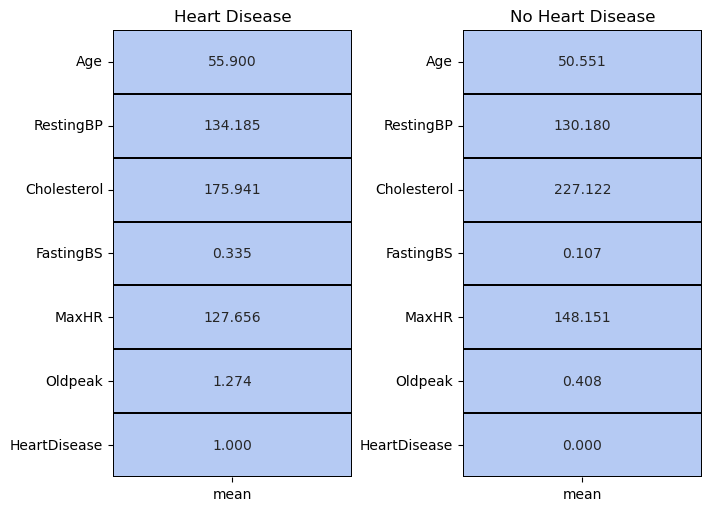

In [6]:
yes = df_heart[df_heart['HeartDisease'] == 1].describe().T
no = df_heart[df_heart['HeartDisease'] == 0].describe().T
custom_colors = ['#B5CAF3']

# build the two panels side‑by‑side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5), 
                         constrained_layout=True)         

sns.heatmap(no[['mean']],  annot=True, ax=axes[1],
            cmap=custom_colors, linewidths=.2, linecolor='black',
            cbar=False, fmt='.3f')
axes[1].set_title('No Heart Disease')

sns.heatmap(yes[['mean']], annot=True, ax=axes[0],
            cmap=custom_colors, linewidths=.2, linecolor='black',
            cbar=False, fmt='.3f')
axes[0].set_title('Heart Disease')



plt.show()


#### *Comments*
- Age: HD cohort older on average (≈ 55.9 y vs 50.6 y).
- Resting BP: Slightly higher in HD group (≈ 134 mmHg vs 130 mmHg).
- Cholesterol: Unexpectedly lower in HD group (≈ 176 mg/dL vs 227 mg/dL), could reflect treatment bias.
- FastingBS: Substantially higher average in HD group (0.335 vs 0.107), suggesting that elevated blood glucose is assocated with greater risk of HD. 
- Max HR: HD patients achieve lower exercise peak (≈ 128 bpm vs 148 bpm).
- Oldpeak (ST‑depression): Markedly higher in HD group (≈ 1.27 mm vs 0.41 mm), can reflect ischemia.

Patterns: Older age, higher resting BP, higher fasting BSgreater ST‑segment depression, and blunted peak HR are associated with heart‑disease cases in this dataset, whereas increased cholesterol shows an inverse relationship with heart-disease here.

## ---VIEW VARIABLE DISTRIBUTIONS---

In [7]:
# convert FastingBS to categorical (since it has only two values)
df_heart['FastingBS'] = df_heart['FastingBS'].astype('object')

# select categorical features
categorical_features = df_heart.select_dtypes(include='object').columns.tolist() 
print("Categorical Features: ", categorical_features)

# target variable
target_variables = ['HeartDisease']

Categorical Features:  ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


### (i) Overall distribution of target variable

/tmp/ipykernel_410646/2148320221.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_heart, x=target_variables[0], ax=ax, palette='coolwarm')


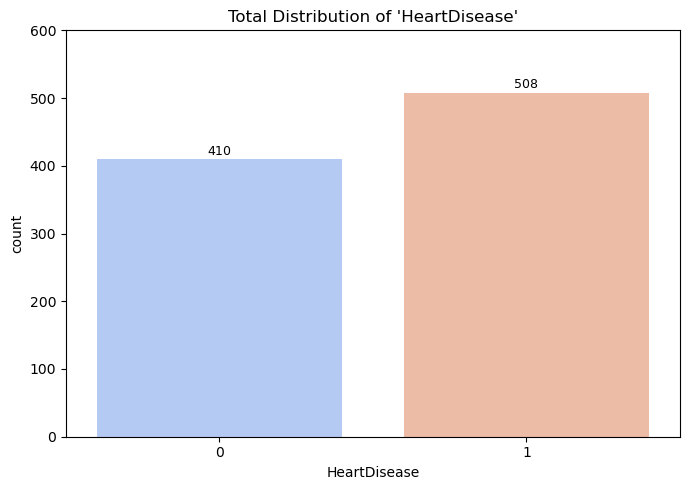

In [8]:
# overall distribution of the target variable (heart disease)
fig, ax = plt.subplots(figsize=(7, 5))

sns.countplot(data=df_heart, x=target_variables[0], ax=ax, palette='coolwarm')
ax.set_ylim(0, 600)
ax.set_title(f"Total Distribution of '{target_variables[0]}'")

for bar in ax.patches:                       
    height = bar.get_height()                
    ax.text(bar.get_x() + bar.get_width()/2, 
            height + 2,                      
            f'{int(height)}',                
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### *Comments*
- Heart disease samples are slightly more common than healthy samples in this dataset.

### (ii) Overall distribution of features

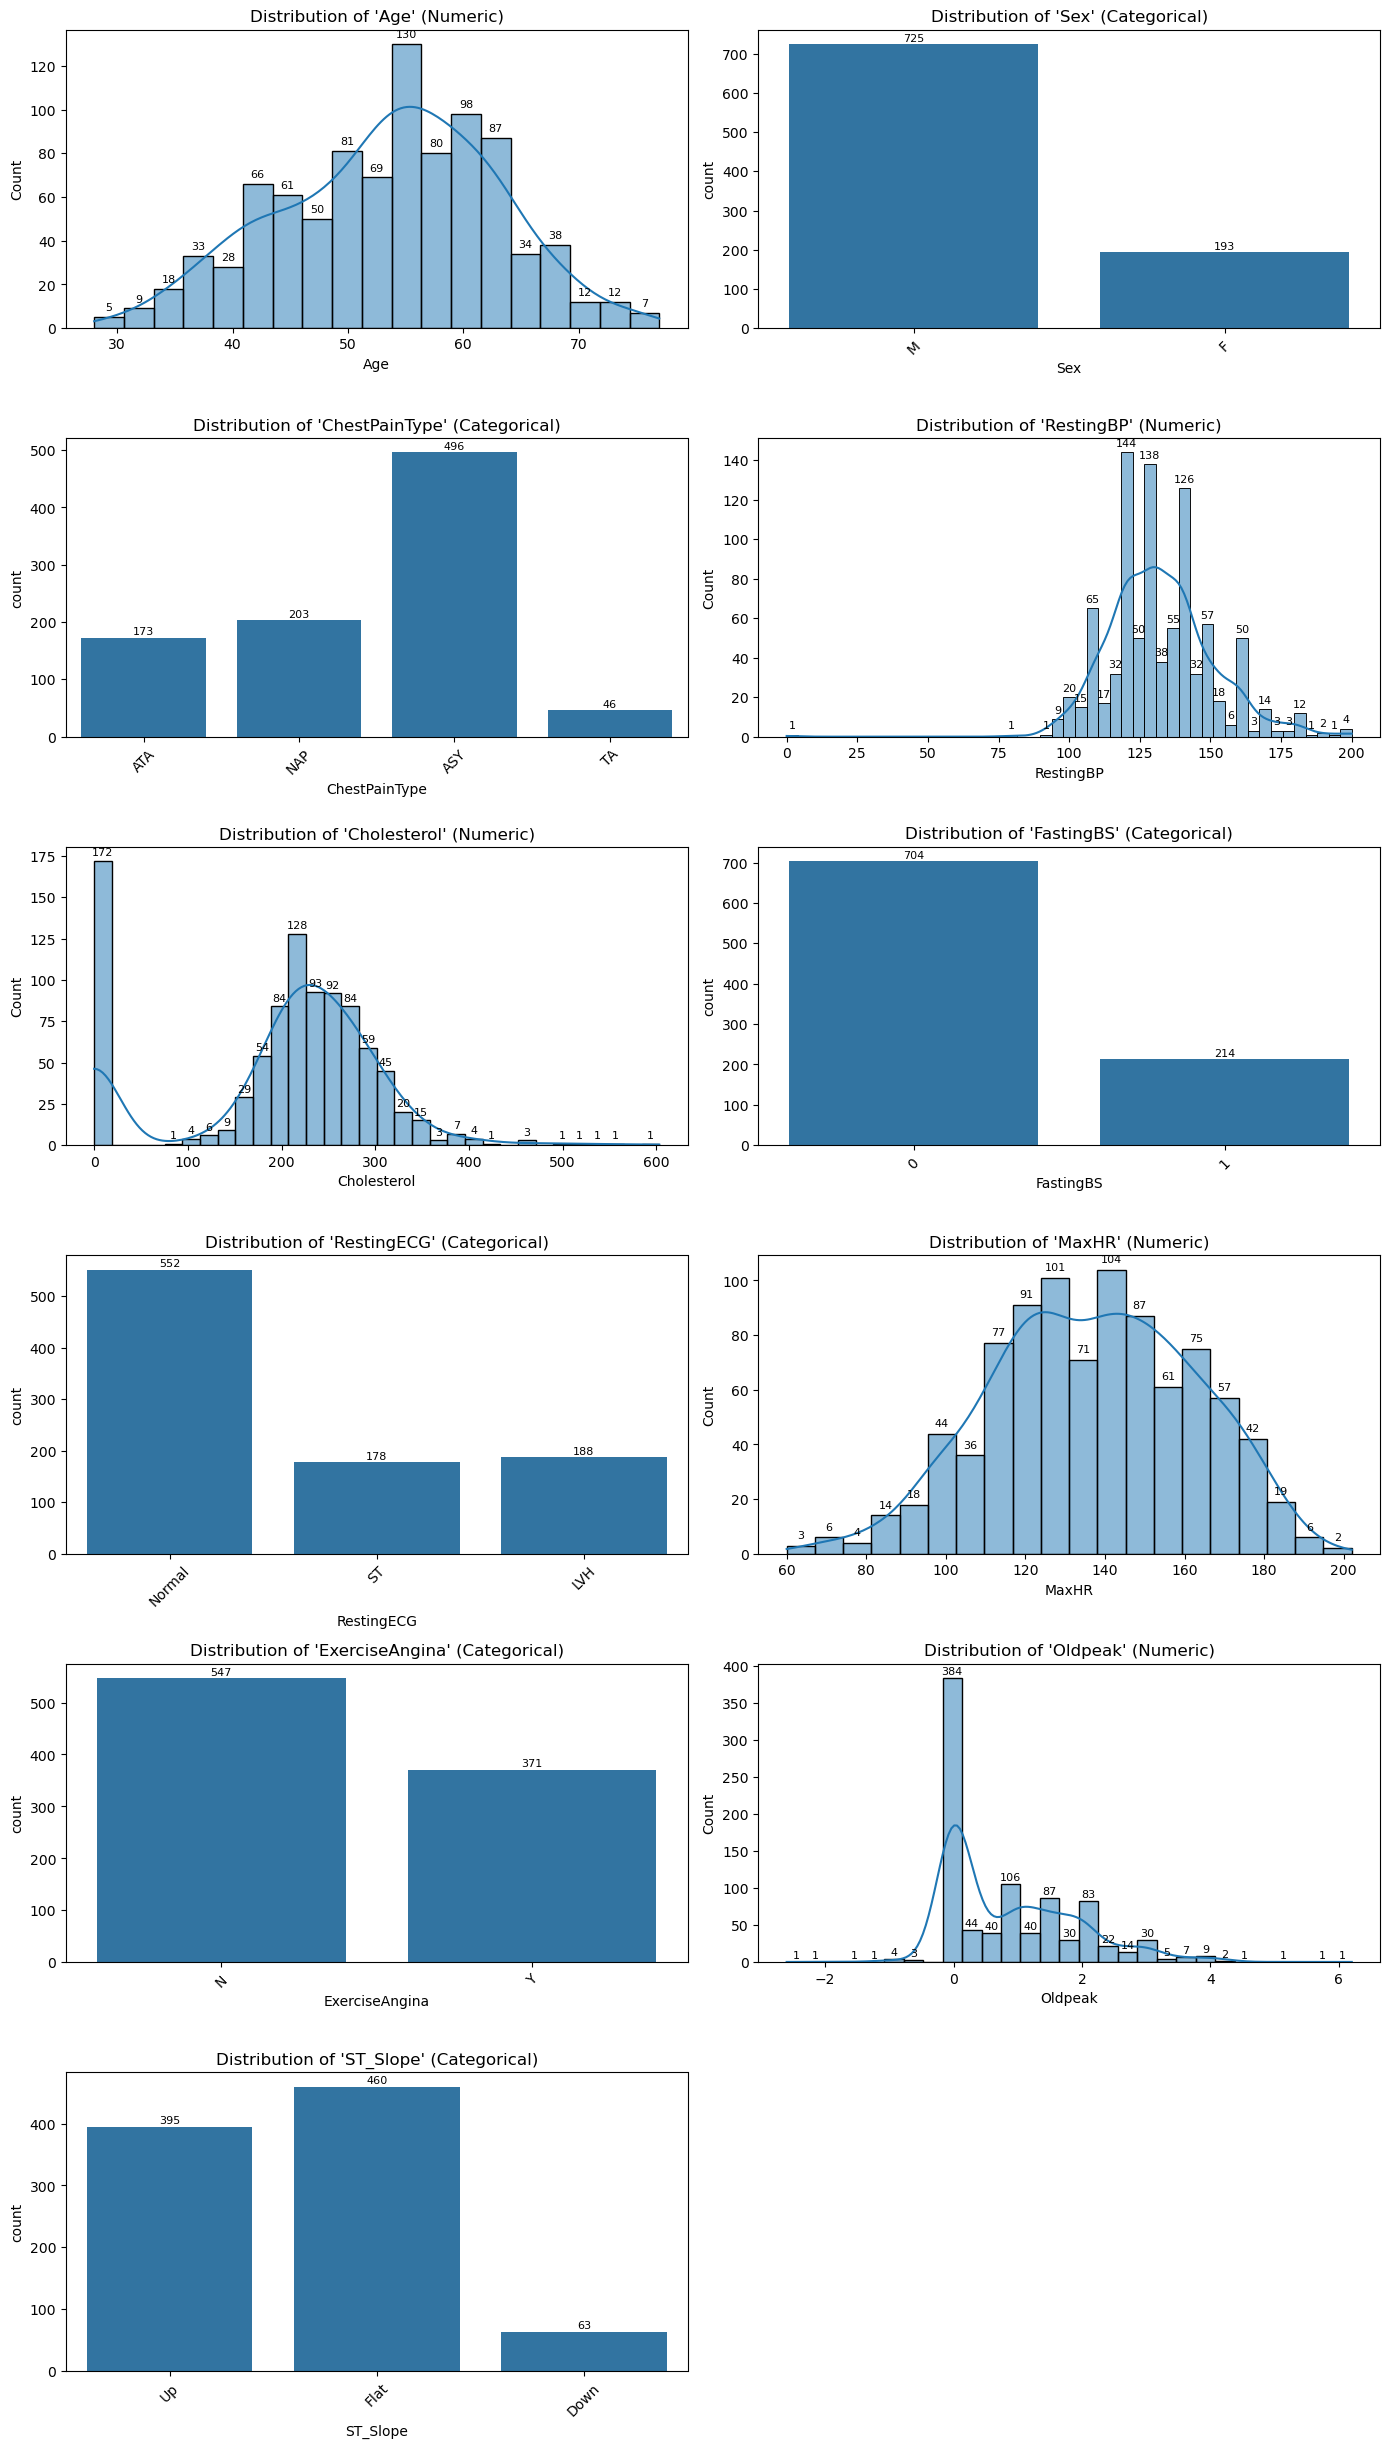

In [9]:
fig, axes = plt.subplots(7, 2, figsize=(14, 28))
axes = axes.flatten()

filtered_columns = [c for c in df_heart.columns if c not in target_variables]

for i, col in enumerate(filtered_columns):
    ax = axes[i]

    if df_heart[col].dtype == 'object': # categorical features  
        sns.countplot(data=df_heart, x=col, ax=ax)
        ax.set_title(f"Distribution of '{col}' (Categorical)")
        plt.setp(ax.get_xticklabels(), rotation=45)

        # add count labels 
        for bar in ax.patches:
            h = bar.get_height()
            if h:
                ax.text(bar.get_x() + bar.get_width() / 2,
                        h + 2,
                        f'{int(h)}',
                        ha='center', va='bottom', fontsize=8)

    else: # numeric features                                        
        sns.histplot(data=df_heart, x=col, kde=True, ax=ax)
        ax.set_title(f"Distribution of '{col}' (Numeric)")

        for bar in ax.patches:
            h = bar.get_height()
            if h:
                ax.text(bar.get_x() + bar.get_width() / 2,
                        h + 2,
                        f'{int(h)}',
                        ha='center', va='bottom', fontsize=8)

# remove any unused panels
for j in range(len(filtered_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## ---FEATURES VS TARGET---

### (i) Categorical Features vs Target Variable (HeartDisease)

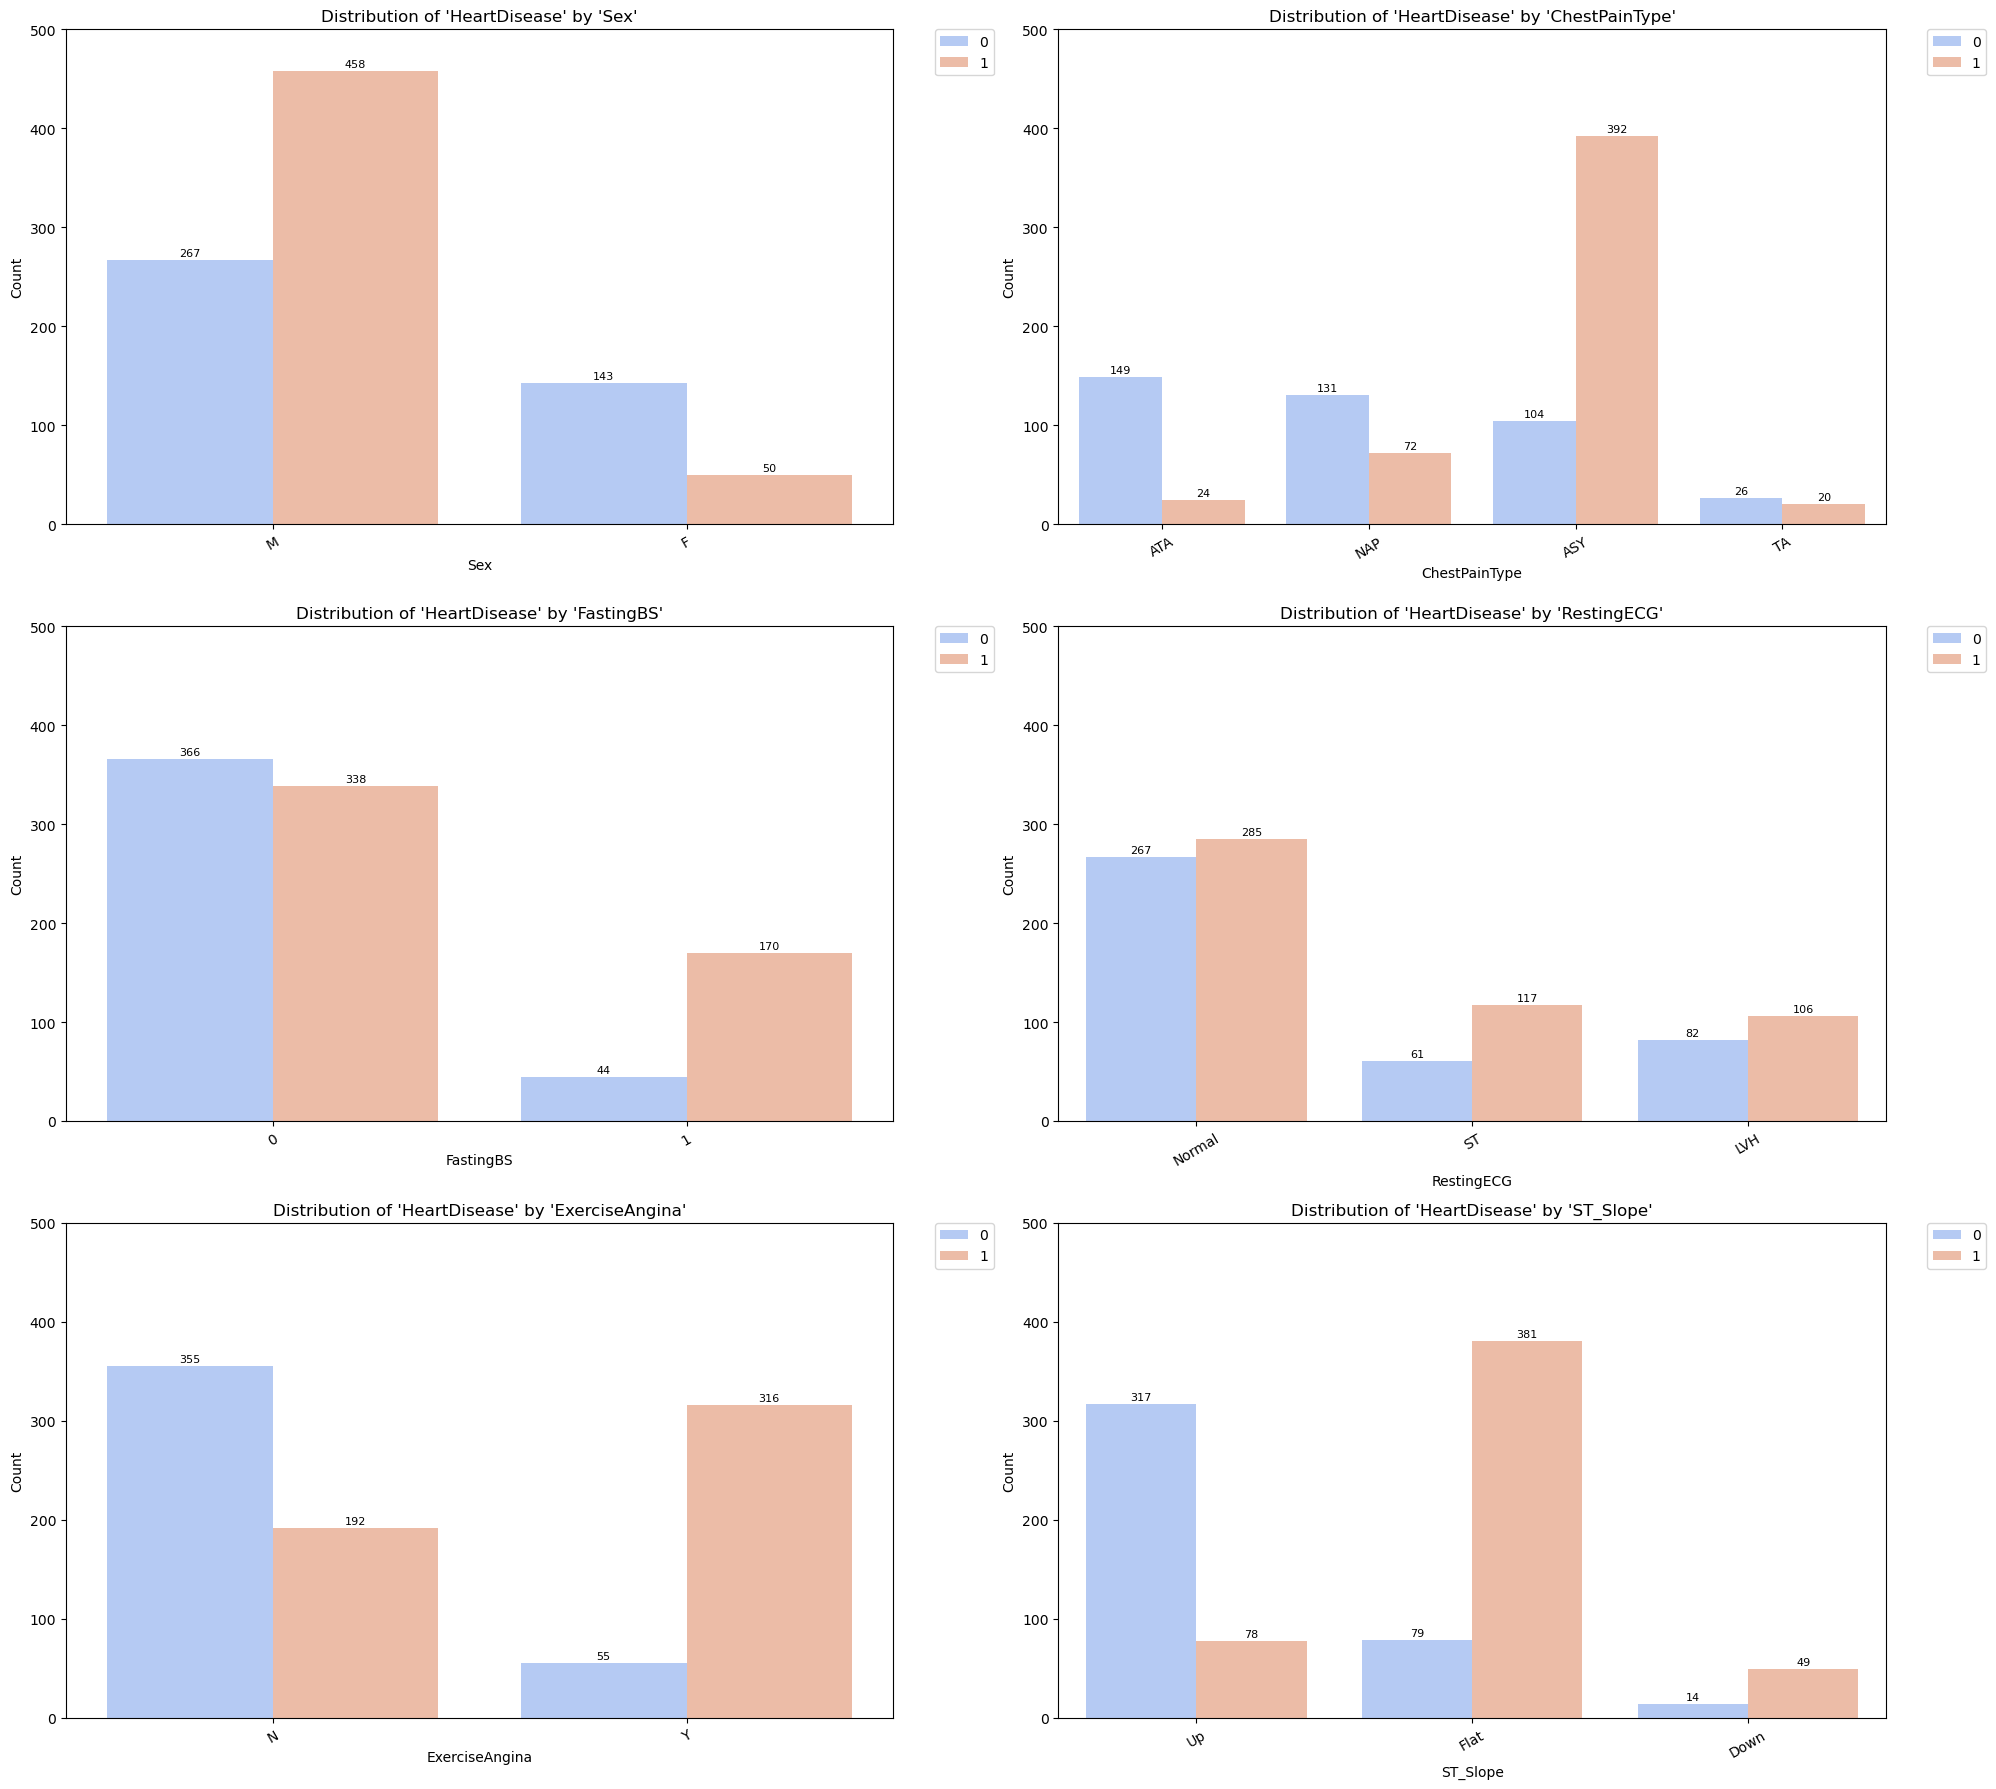

In [10]:
# dynamically create a grid of subplots
n_plots = len(categorical_features) * len(target_variables)
n_cols   = 2
n_rows   = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols*10, n_rows*6))
axes = axes.flatten()

idx = 0
for target in target_variables:
    for feature in categorical_features:
        ax = axes[idx]    

        sns.countplot(data=df_heart,
                      x=feature,
                      hue=target,
                      palette="coolwarm",
                      ax=ax)

        ax.set_title(f"Distribution of '{target}' by '{feature}'")
        ax.set_xlabel(feature)
        ax.set_ylabel("Count")
        ax.set_ylim(0, 500)
        ax.legend(loc='upper left',
                  bbox_to_anchor=(1.05, 1),
                  borderaxespad=0.)
        plt.setp(ax.get_xticklabels(), rotation=30)

        # count labels
        for bar in ax.patches:
            h = bar.get_height()
            if h: 
                ax.text(bar.get_x() + bar.get_width() / 2,
                        h + 2,
                        f'{int(h)}',
                        ha='center', va='bottom', fontsize=8)

        idx += 1   

# hide any unused panels
for ax in axes[idx:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


#### *Comments*
- Males have a higher rate of heart disease compared to females.
- ChestPainType of 'ASY' appears associated with higher rate of heart disease.
- FastingBS of 1 appears associated with higher rate of heart disease.
- RestingECG of 'ST' appears associated with higher rate of heart disease.
- ExerciseAngina is associated with higher rate of heart disease.
- Flat ST_Slope is associated with higher rate of heart disease.

### (ii) Numerical Features vs Target Variable (HeartDisease)

In [11]:
# select numerical features
numeric_features = df_heart.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('HeartDisease')

#### *a. Box Plots*

/tmp/ipykernel_410646/3214213952.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_410646/3214213952.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_410646/3214213952.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_410646/3214213952.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_410646/3214213952.py:10: FutureWa

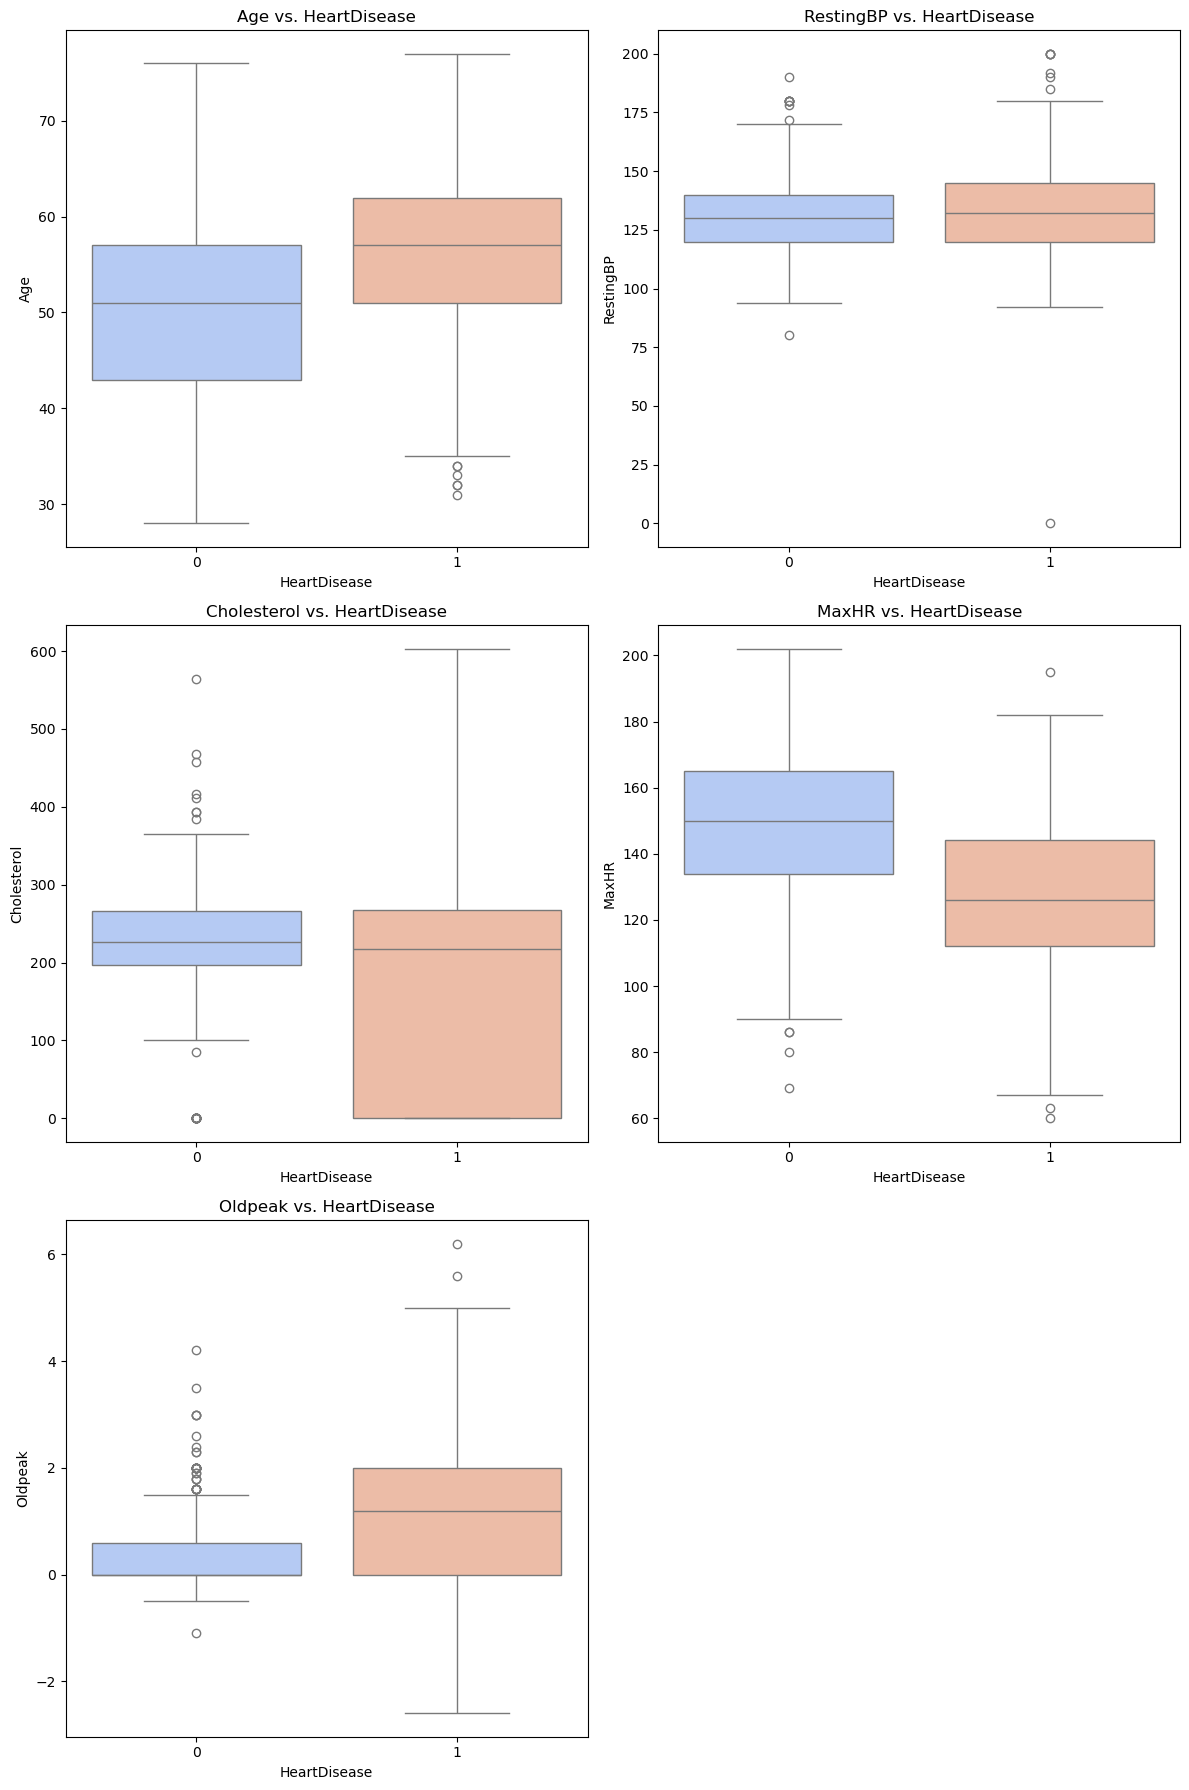

In [12]:
n_features = len(numeric_features)
ncols = 2
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))

axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    sns.boxplot(
        data=df_heart, 
        x='HeartDisease', 
        y=feature, 
        ax=axes[i],
        palette='coolwarm'
    )
    axes[i].set_title(f"{feature} vs. HeartDisease")

#hide any leftover axes (in case n_features is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### *Comments*
- Greater values of Age and Oldpeak appear more correlated with Heart Disease.
- Lower values of MaxHR appear more correlated with Heart Disease.

#### *b. Violin Plots*

/tmp/ipykernel_410646/1568419624.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_410646/1568419624.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_410646/1568419624.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_410646/1568419624.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_410646/1568419624.py:

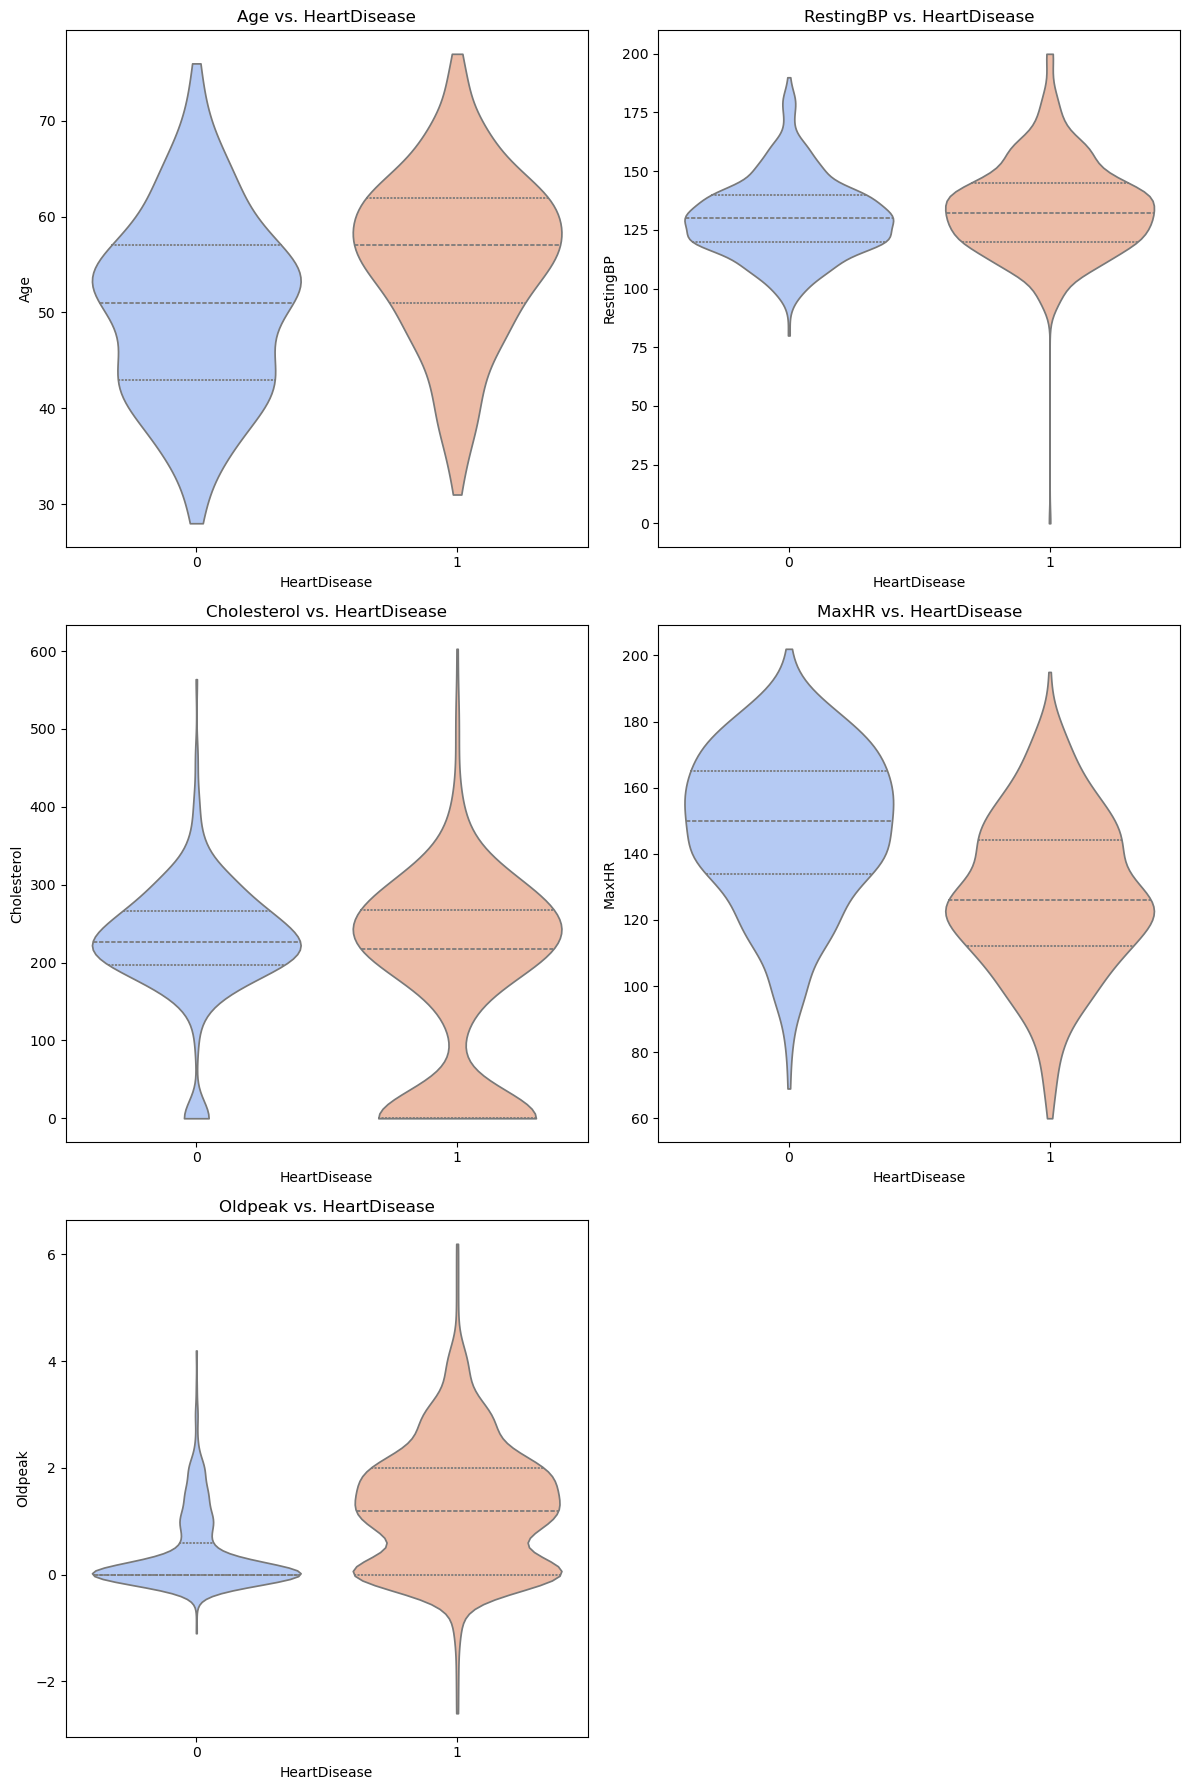

In [13]:
# generate violin plots

n_features = len(numeric_features)
ncols = 2
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    sns.violinplot(
        data=df_heart,
        x='HeartDisease', # binary target on x‑axis
        y=feature, # numeric feature on y‑axis
        ax=axes[i],
        inner="quartile", # show quartiles
        cut=0, # trim violins at min/max of data
        palette='coolwarm'
    )
    axes[i].set_title(f"{feature} vs. HeartDisease")

# hide any leftover axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### *Comments*
- Greater values of Age and Oldpeak appear more correlated with Heart Disease.
- Lower values of MaxHR appear more correlated with Heart Disease.
- (Similar observations as those noted in the box plots)

#### *c. Scatter Plots (Numerical Feature vs Target)*

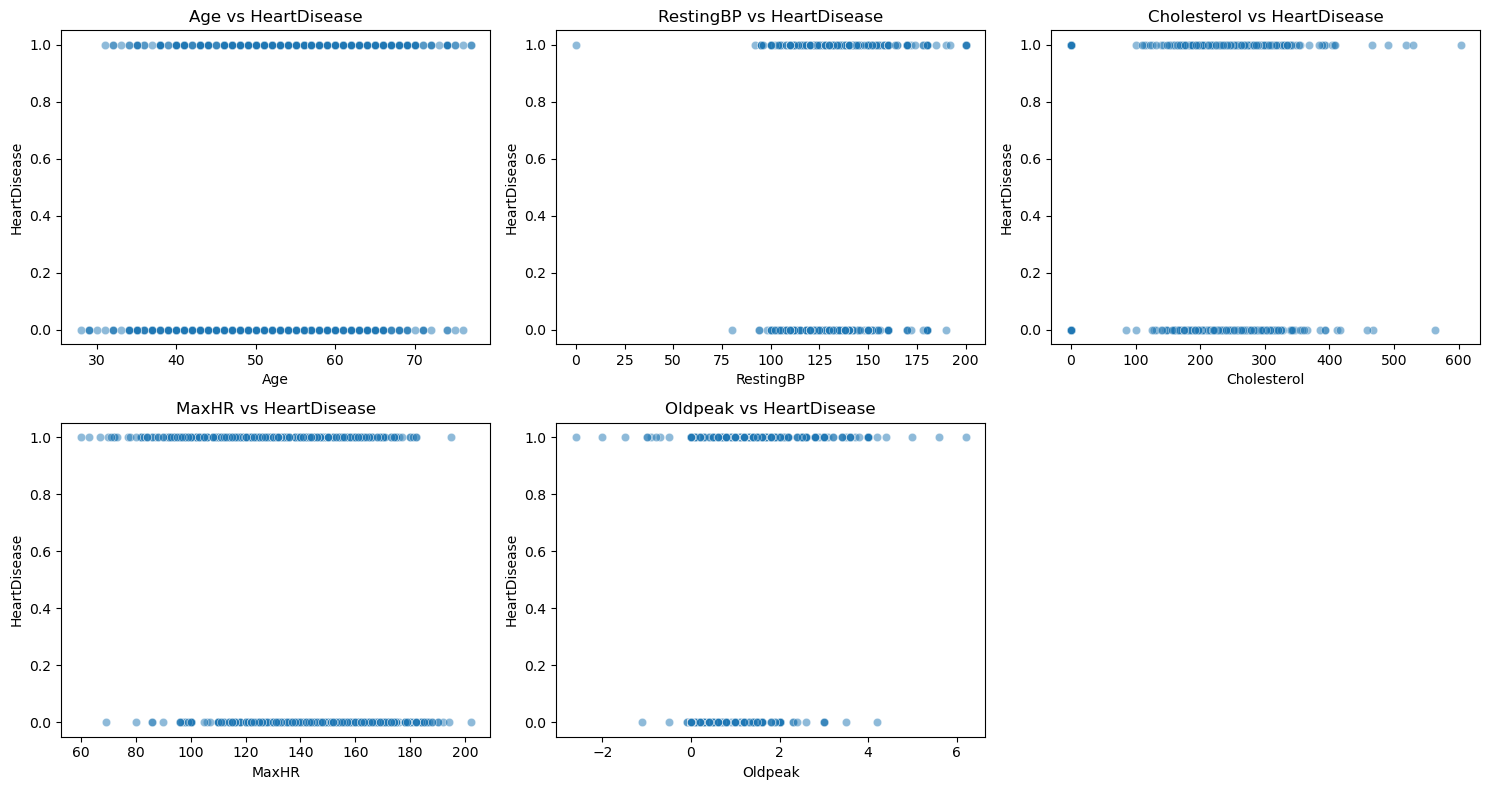

In [14]:
n_cols = 3 # want 3 columns
n_plots = len(numeric_features) * len(target_variables)
n_rows = math.ceil(n_plots / n_cols) # smallest row count that fits everything

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(5 * n_cols, 4 * n_rows),
                         squeeze=False)

axes_flat = axes.flatten() 
idx = 0

for feature in numeric_features:
    for target in target_variables:
        ax = axes_flat[idx]
        sns.scatterplot(data=df_heart,
                        x=feature, y=target,
                        alpha=0.5, ax=ax)
        ax.set_title(f"{feature} vs {target}")
        idx += 1

# hide any leftover blank panels 
for ax in axes_flat[idx:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


#### *Comments*
- Scatter plots don't seem to be the most useful format for visualizing this binary data. Because the y‑axis is binary, a scatterplot stacks all observations onto two horizontal lines, causing heavy over‑plotting that obscures class‑wise distribution patterns.
- Instead, to generate meaningful scatter plots, one must produce Numerical Feature vs Numerical Feature (w.r.t. Target Variable), as demonstrated in the next section.

## ---FEATURES VS. FEATURES---

### (i) Numerical Feature vs Numerical Feature, w.r.t. Target Variable (Heart Disease) - Scatter Plots

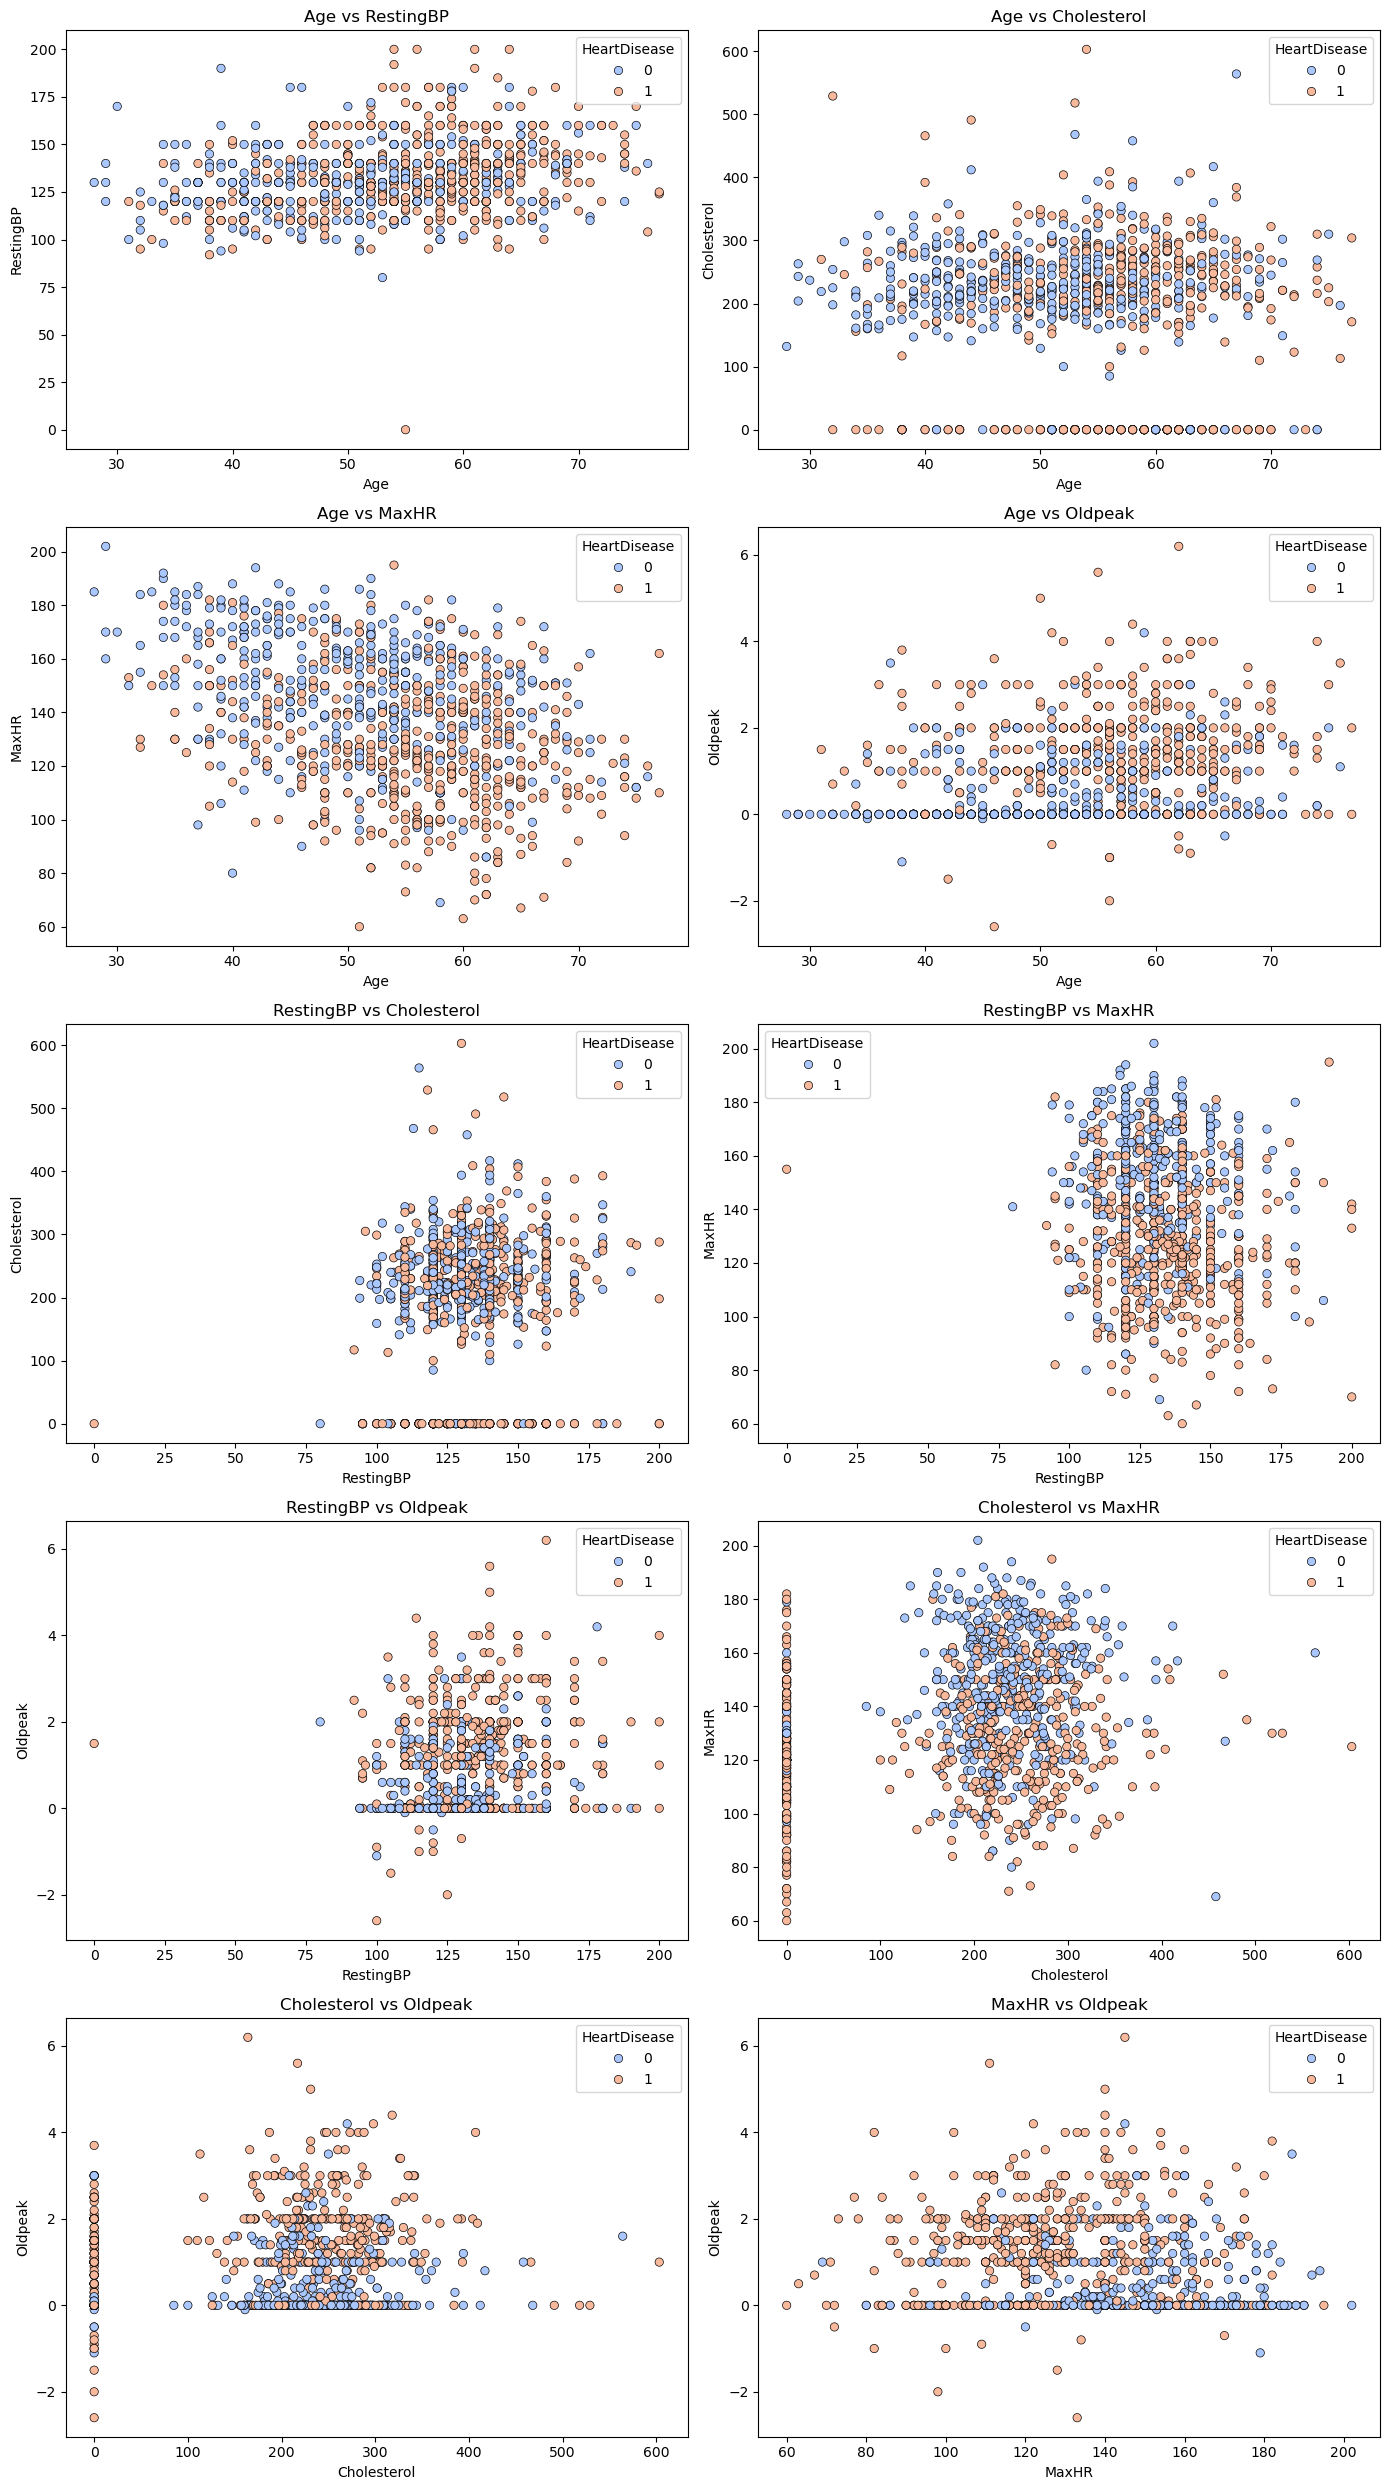

In [15]:
pairs = [(i, j) for i in range(len(numeric_features))
                  for j in range(i + 1, len(numeric_features))]
n_cols = 2
n_rows = math.ceil(len(pairs) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(7 * n_cols, 5 * n_rows),
                         squeeze=False)
axes_flat = axes.flatten()

for k, (i, j) in enumerate(pairs):
    ax = axes_flat[k]
    sns.scatterplot(df_heart,
                    x=numeric_features[i],
                    y=numeric_features[j],
                    hue='HeartDisease',
                    palette='coolwarm',
                    edgecolor='black',
                    ax=ax)
    ax.set_title(f"{numeric_features[i]} vs {numeric_features[j]}")
    ax.legend(title='HeartDisease')

# Hide any leftover empty panels
for ax in axes_flat[len(pairs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


#### *Comments*
- Older age (>50) paired with slower HR (<120) appears associated with greater rate of heart disease.
- Slower HR (<120) appears associated with greater rate of heart disease across all of the horizontal variables.
- Greater Oldpeak appears associated with greater rate of heart disease across all ages (and across all of the other horizontal variables).

### (ii) Numerical Features vs Categorical Features, w.r.t. Target Variable (HeartDisease) - Strip Plots


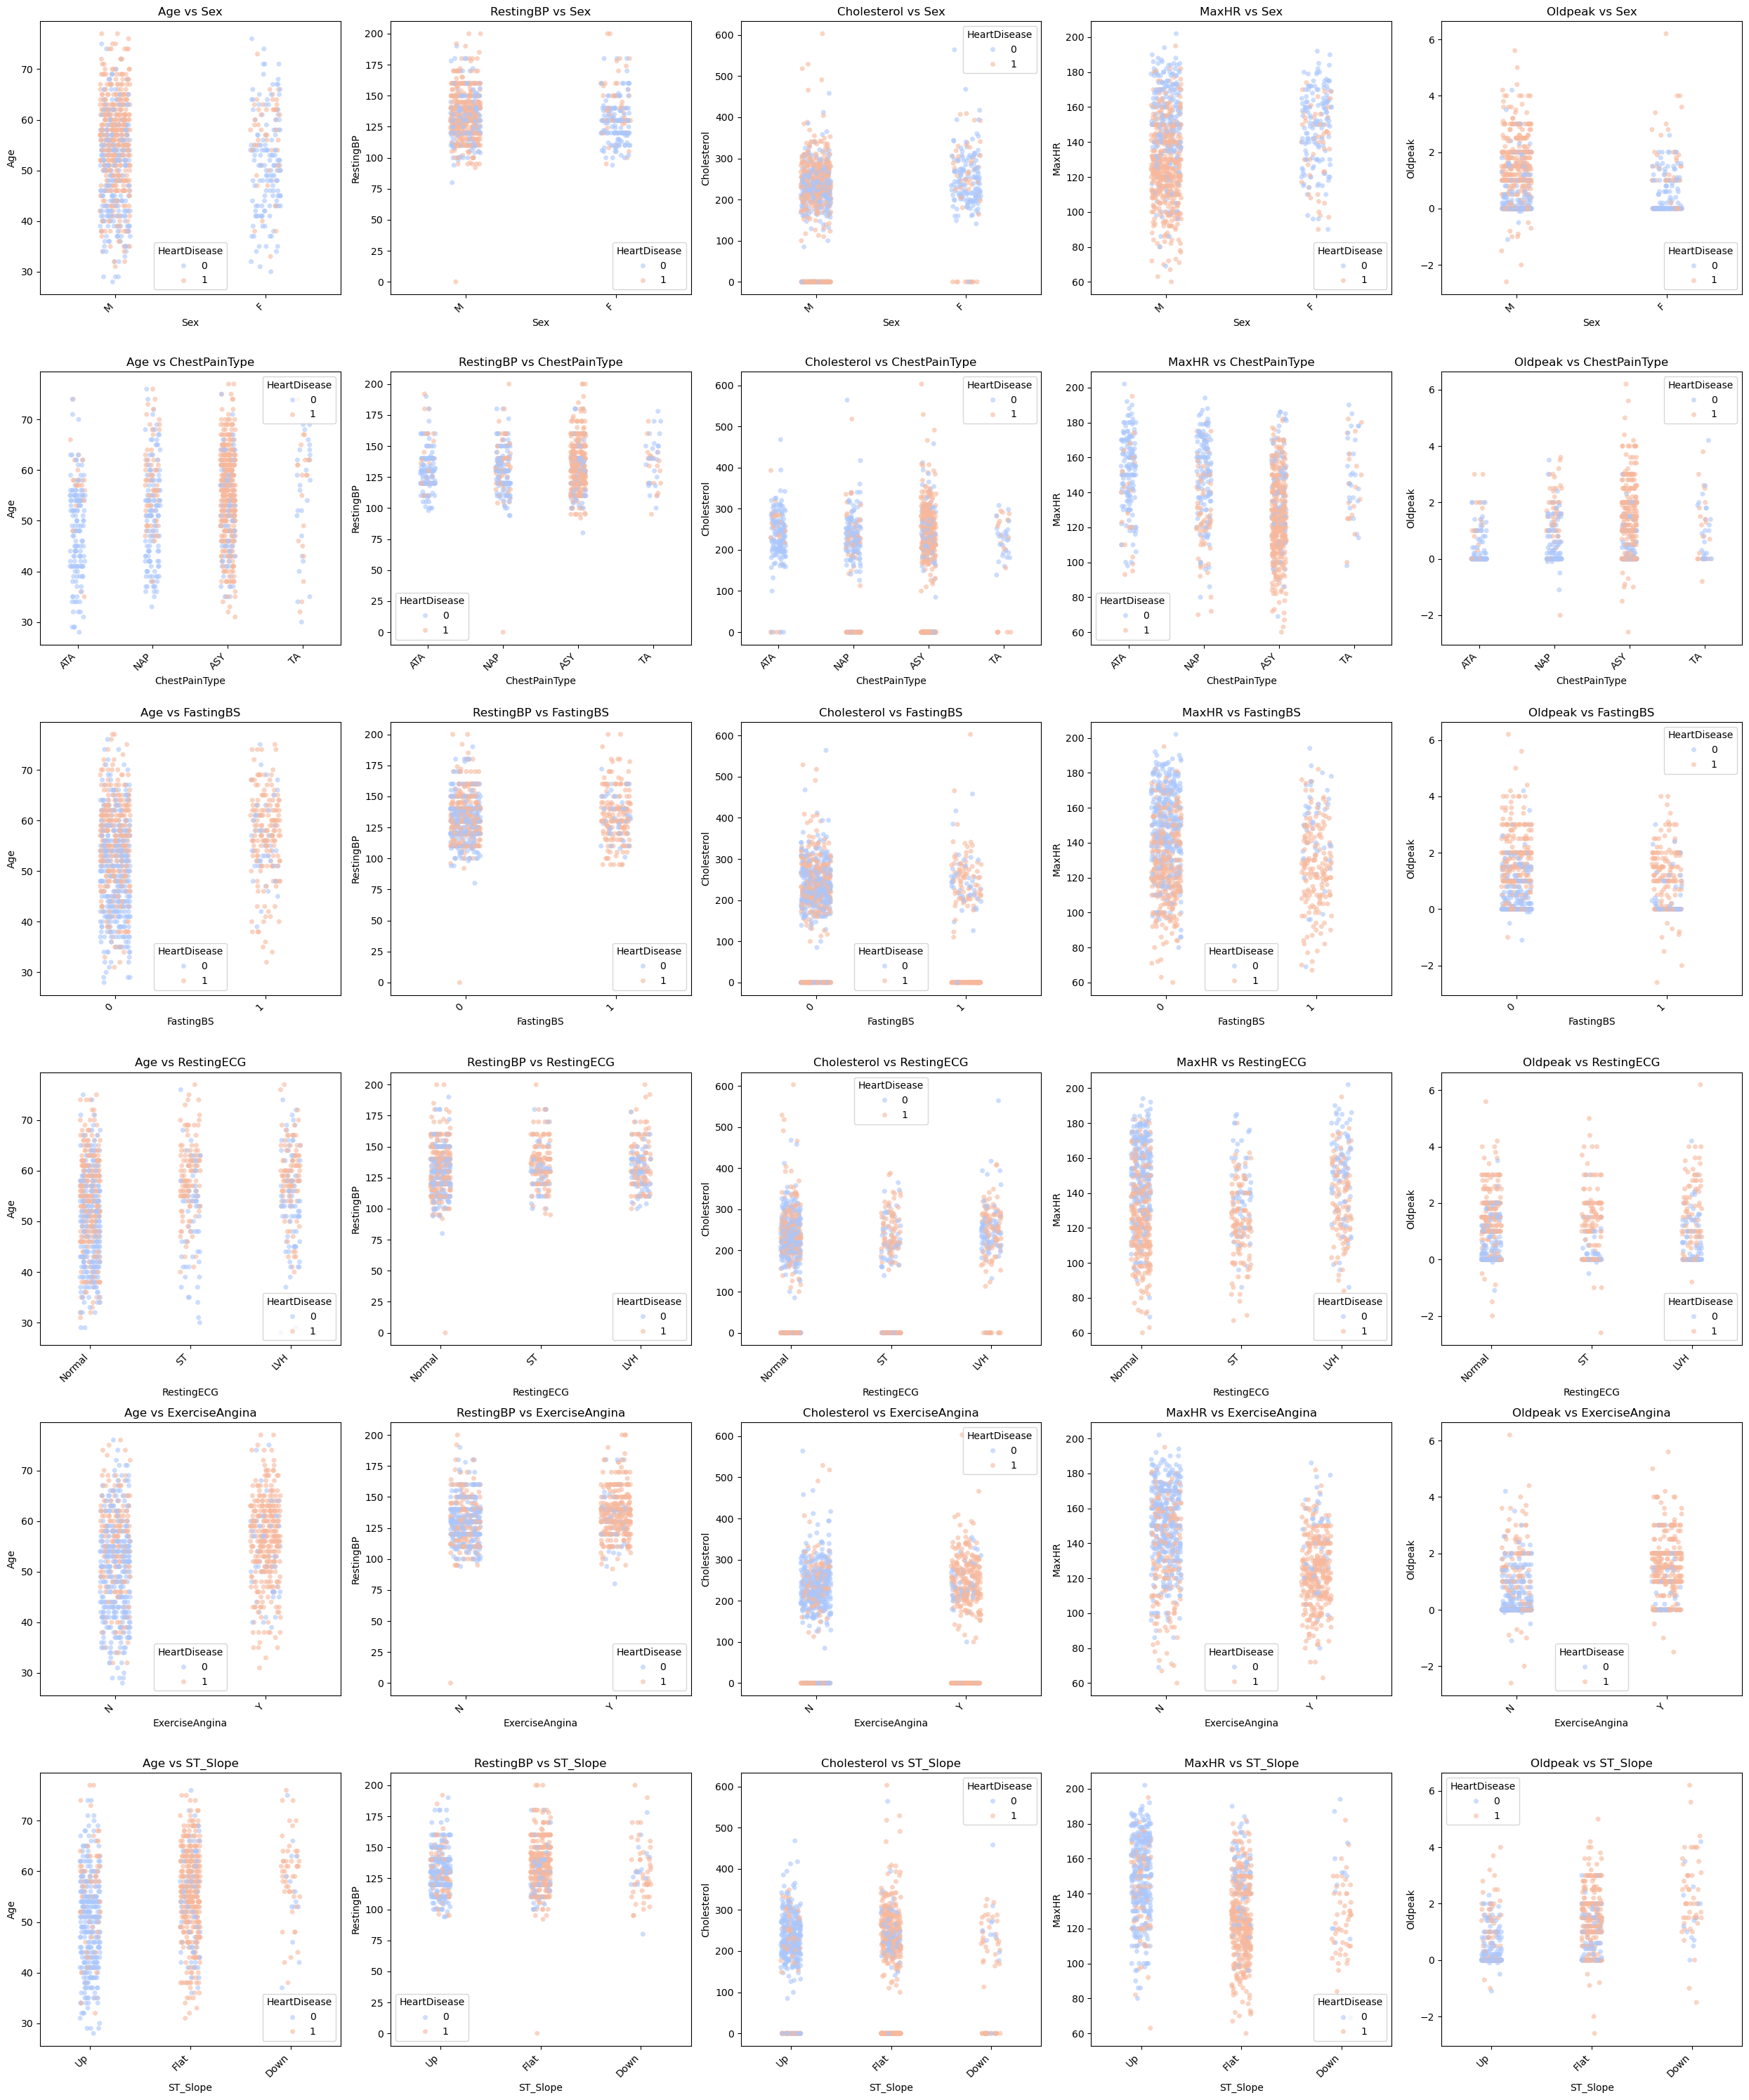

In [16]:
# all combinations of numeric and categorical features
pairs = [(cat, num) for cat in categorical_features for num in numeric_features]

n_cols = 5 # want 5 columns                                          
n_rows = math.ceil(len(pairs) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(5 * n_cols, 5 * n_rows),
                         squeeze=False)
axes = axes.flatten()

for idx, (cat, num) in enumerate(pairs):
    ax = axes[idx]

    sns.stripplot(data=df_heart,
                  x=cat, y=num,
                  hue='HeartDisease',
                  palette='coolwarm',
                  dodge=False, # overlay the two target classes horizontally
                  alpha=0.6,
                  ax=ax)

    ax.set_title(f"{num} vs {cat}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    

# hide any unused panels
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()


#### *Comments*
- Sex: Heart‑disease cases cluster in men across the full feature range—especially age > 50, Oldpeak > 0, and MaxHR < 140. The female sample is more sparse.
- ChestPainType: The asymptomatic (ASY) class is associated with greatest rate of heart disease across every numerical feature.
- FastingBS: Age > 50 shows high event density regardless of FBS status. Hypertensive range RestingBP (> 100 mmHg) plus FBS = 1 elevates risk, whereas cholesterol does not notably stratify events. In FBS = 0 patients, MaxHR < 130 still marks higher risk.
- RestingECG: Any abnormal trace (ST or LVH) is typically associated with events from approximately age 40 upward. Normal traces show events mainly when MaxHR < 140 or Oldpeak > 0.
- ExerciseAngina: Presence of exercise‑induced angina shows a strong, uniform positive association with heart diseaese across all numerical features.
- ST_Slope: Probability of heart disease appears to be Flat > Down > Up, with the Flat slope clearly the highest‑risk category across numerical features.

## ---OVERALL EDA INSIGHTS---

This is a summary of some of the insights we obtained from EDA of the heart disease dataset.

#### Categorical features – risk order (highest > lowest)

- Sex: Male > Female
- Chest Pain Type: ASY > NAP > ATA > TA
- Fasting Blood Sugar (FBS): 1 > 0
- Resting ECG: Normal > ST > LVH
- Exercise‑Induced Angina: Angina present > None
- ST Segment Slope: Flat > Up > Down

#### Numerical features – ranges associated with prominent heart disease rates
- Age: ≥ 50 yr
- Resting BP: 100 ‑ 180 mmHg
- Cholesterol: 120 ‑ 350 mg/dL
- Max Heart Rate: < 140 bpm
- Oldpeak: > 1 mm

#### Overall pattern
- Middle‑aged men (≥ 50 yr) with asymptomatic chest pain, flat ST‑slope, exercise‑induced angina, and “normal” resting ECG appear to be the highest‑risk cohort. (Age ≥ 50  &  MaxHR < 140  &  Oldpeak > 0  &  ST‑Slope = Flat captures large proportion of positive cases.)
- Hyperglycaemia alone does not separate risk
- Serum cholesterol adds little extra discrimination within its 160‑340 mg/dL band.
- Hypertension becomes a stronger signal when paired with either FBS = 1, exercise‑induced angina, male, or flat ST slope.
- There is a moderate sample imbalance in sex, with only about 20% of the samples being measured from females.

## ---DATA PREPROCESSING---

#### Data splits (60:20:20 training:val:test)

In [17]:
# data splitting
X = df_heart.drop(columns=["HeartDisease"]) # drop target variables
y = df_heart[["HeartDisease"]] # df with target variables

# use single split for X and y for dev and test sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# now split dev set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42) # 25% of 80% = 20%
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (550, 11)
X_val shape: (184, 11)
X_test shape: (184, 11)
y_train shape: (550, 1)
y_val shape: (184, 1)
y_test shape: (184, 1)


#### Apply StandardScaler to numerical features and OHE to categorical features

In [18]:
num_cols = X_train.select_dtypes(include="number").columns
cat_cols = X_train.select_dtypes(exclude="number").columns

# StandardScaler for numeric features and OHE for categorical features
preproc = ColumnTransformer(
    [("num", StandardScaler(), num_cols),
     ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), cat_cols)], 
    remainder="drop"
) # add drop="First" if need to address multicollinearity in regression

# back up non-preprocessed data
X_train_original= X_train.copy()
X_val_original= X_val.copy()
X_test_original= X_test.copy()

# fit only on training data
preproc.fit(X_train)

# transform every split
X_train = preproc.transform(X_train)
X_val   = preproc.transform(X_val)
X_test  = preproc.transform(X_test)

## ---CORRELATION MATRIX---

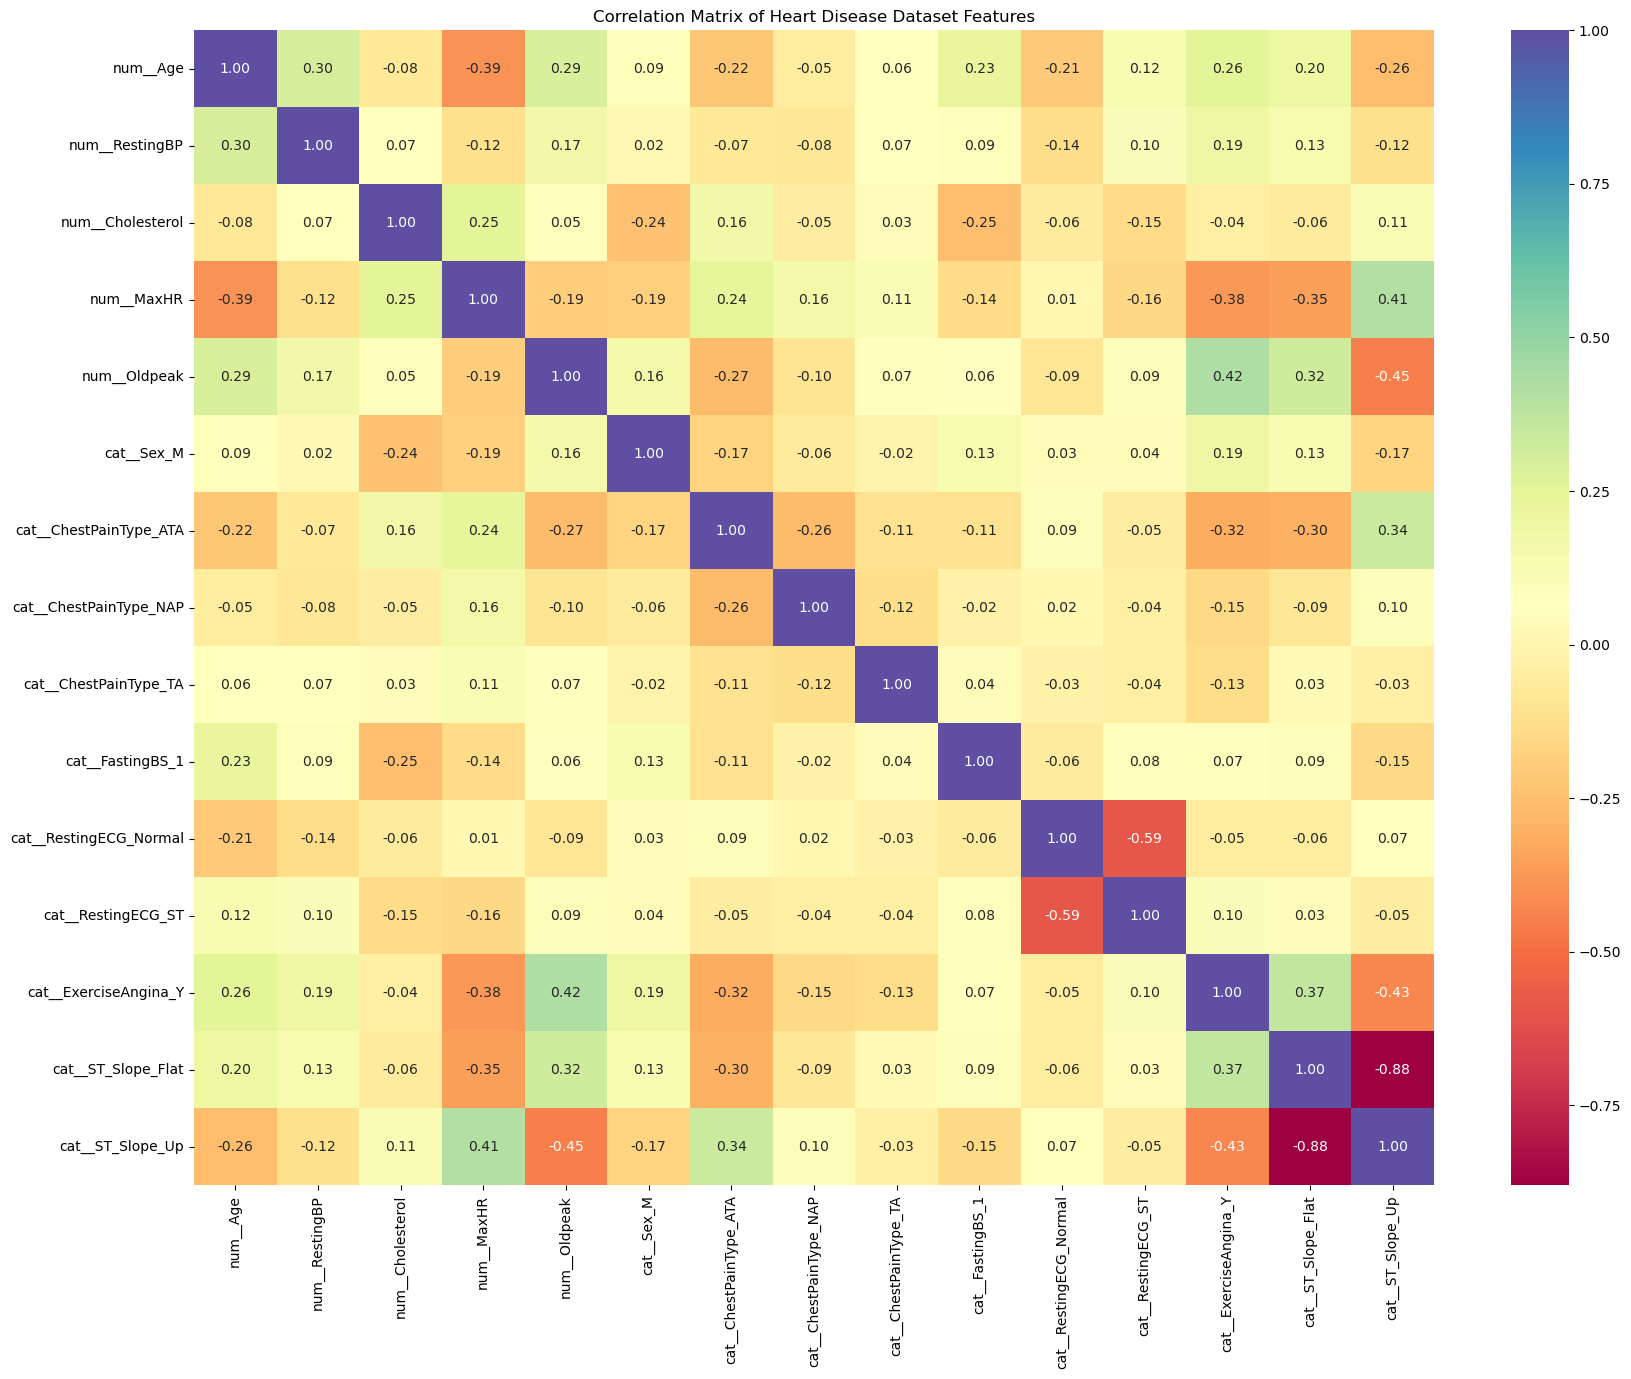

In [19]:
# Correlation matrix

# recreate the DataFrame with preprocessed data
feature_names = preproc.get_feature_names_out()
X_train_df = pd.DataFrame(X_train, columns=feature_names)
corr = X_train_df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, cmap='Spectral', fmt='.2f') 
plt.title('Correlation Matrix of Heart Disease Dataset Features')
plt.show()

#### *Comments*
**A few noteworthy correlation pairs include:**
- Negative correlation between ST_Slope_Up and ST_Slope_Flat (-0.88) that is borderline extreme in magnitude. It is recommended to drop one of these columns for our regression models, due to potential impact of multicollinearity.
- Negative correlation between MaxHR and Age (-0.39). This corresponds with known information about how peak heart rates decrease with age.
- Negative correlation between ST_Slope_Up and ExerciseAngina_Y (-0.43). This corresponds with known information about how up-sloping ST segment during exertion usually reflects adequate myocardial perfusion (i.e. no exercise angina).
- Negative correlation between ST_Slope_Up and Oldpeak (-0.45).